In [10]:
import os
from tqdm import tqdm
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input,Conv2D,Flatten
from tensorflow.keras import optimizers
# from keras.models import Sequential
# from keras.layers import Dense
# from keras import optimizers

import matplotlib.pyplot as plt
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"] = '4'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
from nerf_helper import *


cuda


In [11]:
def nerf_forward(rays_o,rays_d,near,far,encoding_fn,coarse_model,kwargs_sample_stratified = None,n_samples_hierarchical = 0
                 ,kwargs_sample_hierarchical = None,fine_model = None,viewdirs_encoding_fn = None,chunksize = 2**15):
    # Set no kwargs if none are given.
    if kwargs_sample_stratified is None:
        kwargs_sample_stratified = {}
    if kwargs_sample_hierarchical is None:
        kwargs_sample_hierarchical = {}

    # Sample query points along each ray.
    query_points, z_vals = sample_stratified(
      rays_o, rays_d, near, far, **kwargs_sample_stratified)

    # Prepare batches.
    batches = prepare_chunks(query_points, encoding_fn, chunksize=chunksize)
    if viewdirs_encoding_fn is not None:
        batches_viewdirs = prepare_viewdirs_chunks(query_points, rays_d,
                                                   viewdirs_encoding_fn,
                                                   chunksize=chunksize)
    else:
        batches_viewdirs = [None] * len(batches)

    # Coarse model pass.
    # Split the encoded points into "chunks", run the model on all chunks, and
    # concatenate the results (to avoid out-of-memory issues).
    predictions = []
    for batch, batch_viewdirs in zip(batches, batches_viewdirs):
        predictions.append(coarse_model(batch, viewdirs=batch_viewdirs))
    
    raw = torch.cat(predictions, dim=0)
    raw = raw.reshape(list(query_points.shape[:2]) + [raw.shape[-1]])

    # Perform differentiable volume rendering to re-synthesize the RGB image.
    rgb_map, depth_map, acc_map, weights = raw2outputs(raw, z_vals, rays_d)
    
    outputs = {'z_vals_stratified': z_vals}

    # Fine model pass.
    if n_samples_hierarchical > 0:
        # Save previous outputs to return.
        rgb_map_0, depth_map_0, acc_map_0 = rgb_map, depth_map, acc_map

        # Apply hierarchical sampling for fine query points.
        query_points, z_vals_combined, z_hierarch = sample_hierarchical(rays_o, rays_d, z_vals, weights
                                                                        ,n_samples_hierarchical
                                                                        ,**kwargs_sample_hierarchical)

        # Prepare inputs as before.
        batches = prepare_chunks(query_points, encoding_fn, chunksize=chunksize)
        if viewdirs_encoding_fn is not None:
            batches_viewdirs = prepare_viewdirs_chunks(query_points, rays_d,
                                                     viewdirs_encoding_fn,
                                                     chunksize=chunksize)
        else:
            batches_viewdirs = [None] * len(batches)

        # Forward pass new samples through fine model.
        fine_model = fine_model if fine_model is not None else coarse_model
        predictions = []
        for batch, batch_viewdirs in zip(batches, batches_viewdirs):
            predictions.append(fine_model(batch, viewdirs=batch_viewdirs))
            
        raw = torch.cat(predictions, dim=0)
        raw = raw.reshape(list(query_points.shape[:2]) + [raw.shape[-1]])

        # Perform differentiable volume rendering to re-synthesize the RGB image.
        rgb_map, depth_map, acc_map, weights = raw2outputs(raw, z_vals_combined, rays_d)

        # Store outputs.
        outputs['z_vals_hierarchical'] = z_hierarch
        outputs['rgb_map_0'] = rgb_map_0
        outputs['depth_map_0'] = depth_map_0
        outputs['acc_map_0'] = acc_map_0

    # Store outputs.
    outputs['rgb_map'] = rgb_map
    outputs['depth_map'] = depth_map
    outputs['acc_map'] = acc_map
    outputs['weights'] = weights
    return outputs

In [12]:
trans_t = lambda t : torch.Tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1]]).float()

rot_phi = lambda phi : torch.Tensor([
    [1,0,0,0],
    [0,np.cos(phi),-np.sin(phi),0],
    [0,np.sin(phi), np.cos(phi),0],
    [0,0,0,1]]).float()

rot_theta = lambda th : torch.Tensor([
    [np.cos(th),0,-np.sin(th),0],
    [0,1,0,0],
    [np.sin(th),0, np.cos(th),0],
    [0,0,0,1]]).float()


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = torch.Tensor(np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]])) @ c2w
    return c2w

In [13]:
def load_data(tgt_class, json_path,resized_res=False):
    
    with open(json_path, 'r') as fp:
        meta = json.load(fp)

    imgs = []
    poses = []

    if 'frames' in meta.keys():
        print('this is colmap camera data..')
        for num in meta['frames']:
            frame = meta['frames']
            path = frame[num]['file_path']
            img_fn = path.split('/')[-1]
            imgs.append(imageio.imread(f'./dataset/data_square/{tgt_class}/'+img_fn))
            poses.append(np.array(frame[num]['transform_matrix']))
            
        imgs = (np.array(imgs) / 255.).astype(np.float32) # keep all 4 channels (RGBA)
        poses = np.array(poses).astype(np.float32)
        camera_angle_x = float(meta['camera_angle_x']['0'])
        H, W = imgs.shape[1:3]
        focal = .5 * W / np.tan(.5 * camera_angle_x)    
        
    if resized_res:
        #print(resized_res,':',H,W,focal,'-->',H//resized_res,W//resized_res,focal/resized_res)
        H = H//resized_res
        W = W//resized_res
        focal = focal/resized_res
        
        imgs_reszed_res = np.zeros((imgs.shape[0], H, W, 3))
        for i, img in enumerate(imgs):
            imgs_reszed_res[i] = cv2.resize(img, (W, H), interpolation=cv2.INTER_AREA)
        imgs = imgs_reszed_res

    data = {'images':imgs, 'poses':poses, 'focal':np.array(focal)}
    print(f'Images shape: {imgs.shape}',f'Poses shape: {poses.shape}',f'Focal length: {focal}')
    return data

In [14]:
tgt_class   = '1-5-16_12_knitted-toy-cat-stand_3_2_1_polygon'
colmap_data = load_data(tgt_class,json_path=f'./dataset/colmap_cameras.json',resized_res=6)

this is colmap camera data..


/tmp/ipykernel_67297/1525600301.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgs.append(imageio.imread(f'./dataset/data_square/{tgt_class}/'+img_fn))


Images shape: (24, 180, 180, 3) Poses shape: (24, 4, 4) Focal length: 202.61784009410098


In [15]:
resized_res = 6
all_imgs = []
all_files_n = [] 

for i in np.arange(24):
    
    zfiil_n = str(i).zfill(2)
    img_fn = 'image_view{}.png'.format(zfiil_n)
    all_imgs.append(imageio.imread(f'./dataset/data_square/{tgt_class}/'+img_fn))
    all_files_n.append(img_fn)
    
all_imgs = (np.array(all_imgs) / 255.).astype(np.float32) # keep all 4 channels (RGBA)

H, W = all_imgs.shape[1:3]

if resized_res:
    #print(resized_res,':',H,W,focal,'-->',H//resized_res,W//resized_res,focal/resized_res)
    H = H//resized_res
    W = W//resized_res

    imgs_reszed_res = np.zeros((all_imgs.shape[0], H, W, 3))
    for i, img in enumerate(all_imgs):
        imgs_reszed_res[i] = cv2.resize(img, (W, H), interpolation=cv2.INTER_AREA)
    all_imgs = imgs_reszed_res


/tmp/ipykernel_67297/54471638.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  all_imgs.append(imageio.imread(f'./dataset/data_square/{tgt_class}/'+img_fn))


In [16]:
len(all_files_n)

24

In [17]:
testset = {'file_names':[],'images':[],'poses':[]}
for i,n in enumerate(all_files_n):
    if n not in colmap_data['file_names']:
        print(n)
        testset['file_names'].append(n)
        testset['images'].append(all_imgs[i])
        plt.imshow(all_imgs[i])
        plt.show()
    else:
        pass

KeyError: 'file_names'

In [18]:
height, width = colmap_data['images'].shape[1:3]
height = torch.from_numpy(np.array(height)).to(device).float()
width = torch.from_numpy(np.array(width)).to(device).float()
focal = torch.from_numpy(colmap_data['focal']).to(device).float()
poses = torch.from_numpy(colmap_data['poses']).to(device).float()
images = colmap_data['images']


In [19]:
my_poses = []
for th in np.linspace(0., 360., 200, endpoint=False):
    c2w = pose_spherical(th, -40., 3.7)
    my_poses.append(c2w.detach().cpu().numpy())


for th in np.linspace(0., 360., 200, endpoint=False):
    c2w = pose_spherical(th, -2., 4.2)
    my_poses.append(c2w.detach().cpu().numpy())
    
my_poses = np.array(my_poses)

In [20]:
def plot_viewdirs(viewdirs=None,view=(90,-90),color='blue',label='none'):

    vectors    = np.stack([np.sum([0, 0, -1] * pose[:3, :3], axis=-1) for pose in viewdirs])

    X = vectors[..., 0].flatten()
    Y = vectors[..., 1].flatten()
    Z = vectors[..., 2].flatten()

    origins = viewdirs[:, :3, -1]
    origin_X = origins[..., 0].flatten(),
    origin_Y = origins[..., 1].flatten(),
    origin_Z = origins[..., 2].flatten(),

    _ = ax.quiver(origin_X, origin_Y, origin_Z, X, Y, Z, length=1, color=color, normalize=True, label=label,alpha=0.4)
    
    ax.set_xlim([-4, 4])
    ax.set_ylim([-4, 4])
    ax.set_zlim([-4, 4])
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    plt.legend()
    plt.title('My camera poses')
    ax.view_init(view[0],view[1])


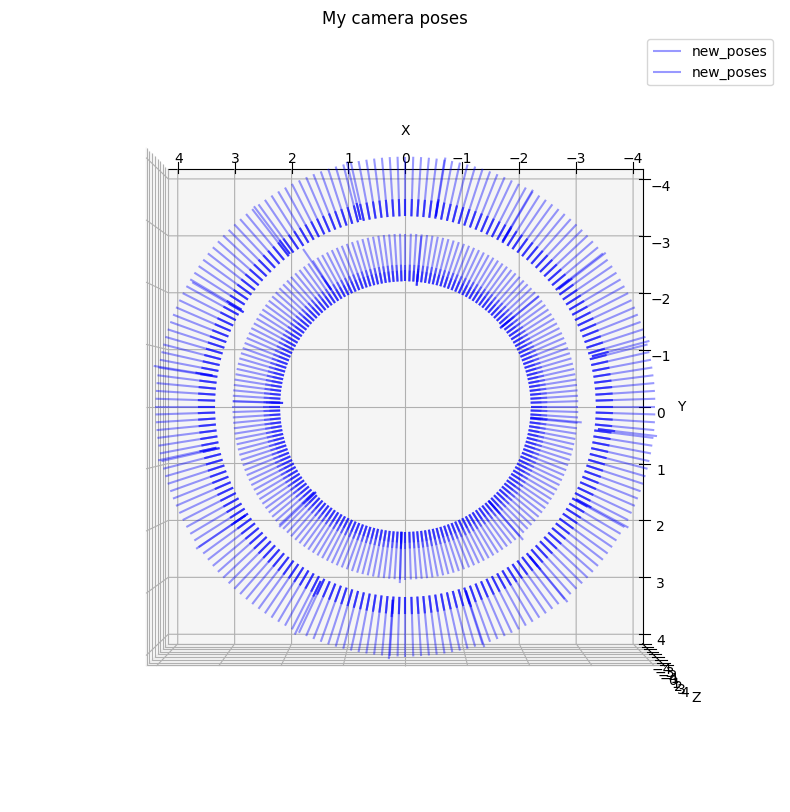

In [21]:
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
plot_viewdirs(viewdirs=poses.detach().cpu().numpy(),view=(25,90),color='blue',label='new_poses')
plot_viewdirs(viewdirs=my_poses,view=(90,90),color='blue',label='new_poses')
plt.show()

In [22]:
def init_models(device):
    # Encoders
    encoder = PositionalEncoder(d_input, n_freqs, log_space=log_space)
    encode = lambda x: encoder(x)

    # View direction encoders
    if use_viewdirs:
        encoder_viewdirs = PositionalEncoder(d_input, n_freqs_views,log_space=log_space)
        encode_viewdirs = lambda x: encoder_viewdirs(x)
        d_viewdirs = encoder_viewdirs.d_output
    else:
        encode_viewdirs = None
        d_viewdirs = None

    # Models
    model = NeRF(encoder.d_output, n_layers=n_layers, d_filter=d_filter, skip=skip,d_viewdirs=d_viewdirs)
    model.to(device)
    model_params = list(model.parameters())
    if use_fine_model:
        fine_model = NeRF(encoder.d_output, n_layers=n_layers, d_filter=d_filter, skip=skip,
                          d_viewdirs=d_viewdirs)
        fine_model.to(device)
        model_params = model_params + list(fine_model.parameters())
    else:
        fine_model = None

    # Optimizer
    optimizer = torch.optim.Adam(model_params, lr=np.float32(lr))

    # Early Stopping
    warmup_stopper = EarlyStopping(patience=50)

    return model, fine_model, encode, encode_viewdirs, optimizer, warmup_stopper

In [23]:
_, _, encode, encode_viewdirs, optimizer, warmup_stopper = init_models(device)
ckpt = torch.load('./logs/model/{}_model.tar'.format(tgt_class))
model, fine_model = ckpt['model'], ckpt['fine_model']

In [24]:
near, far = 2., 6.

In [25]:
def pose_to_rgb(pose):
    pose = torch.from_numpy(np.array(pose)).to(device).float()
    rays_o, rays_d = get_rays(height, width, focal, pose)
    rays_o = rays_o.reshape([-1, 3])
    rays_d = rays_d.reshape([-1, 3])

    outputs = nerf_forward(rays_o, rays_d,
                         near, far, encode, model,
                         kwargs_sample_stratified=kwargs_sample_stratified,
                         n_samples_hierarchical=n_samples_hierarchical,
                         kwargs_sample_hierarchical=kwargs_sample_hierarchical,
                         fine_model=fine_model,
                         viewdirs_encoding_fn=encode_viewdirs,
                         chunksize=2**15)

    image = outputs['rgb_map']#.astype(np.uint8)
    image = image.reshape(int(width.item()),int(height.item()),3)
    image = image.detach().cpu().numpy()
    return image

In [26]:
pred_imgs = []
for pose in tqdm(my_poses):

    img = pose_to_rgb(pose)

 15%|███████████████▍                                                                                       | 60/400 [00:06<00:36,  9.19it/s]


KeyboardInterrupt: 

In [ ]:
X = np.concatenate([pred_imgs,images])
Y = np.concatenate([my_poses,poses.detach().cpu().numpy()])

Y = np.array([y.flatten() for y in Y])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=777,shuffle=True)
print(x_train.shape,x_test.shape)

In [ ]:
dnn_model = Sequential()
dnn_model.add(Conv2D(input_shape = (180, 180, 3), filters = 32, kernel_size = (5,5), strides = (2,2), padding = 'valid'))
dnn_model.add(Conv2D(filters = 32, kernel_size = (5,5), strides = (2,2), padding = 'valid'))
dnn_model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = (2,2), padding = 'valid'))
dnn_model.add(Conv2D(filters = 128, kernel_size = (3,3), strides = (2,2), padding = 'valid'))
dnn_model.add(Flatten())
dnn_model.add(Dense(1000, activation='gelu'))
dnn_model.add(Dense(1000, activation='gelu'))
dnn_model.add(Dense(1000, activation='gelu'))
dnn_model.add(Dense(512, activation='gelu'))
dnn_model.add(Dense(16, activation='linear'))

In [ ]:
# model fit

adam = optimizers.Adam(learning_rate = 0.0001)
dnn_model.compile(loss='mse',optimizer=adam)

dnn_model.summary()

history = dnn_model.fit(x_train, y_train,validation_data=(x_test,y_test),
                    epochs=100, batch_size=16, shuffle=False, verbose=1)


In [ ]:
# 학습 정확성 값과 검증 정확성 값을 플롯팅 합니다. 
#print(history.history)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Loss'], loc='upper left')
plt.savefig('tran_result.png')
#plt.show()

In [ ]:
y_pred = dnn_model.predict(x_test)

In [ ]:
testset['poses'] = []
for i in range(len(testset['images'])):
    img = testset['images'][i].reshape(1,180,180,3)
    testset['poses'].append(dnn_model.predict(img).reshape(4,4))

In [ ]:
for i in range(3):
    dict_ = {'file_path': f"./dog/{testset['file_names'][i]}"
         ,'sharpness' : 392.0
         ,'transform_matrix' : testset['poses'][i].tolist()}
    
    meta['frames'].append(dict_)

In [ ]:
import pandas as pd 
pd.DataFrame(meta).to_json('colmap_cameras_new.json')